<a href="https://colab.research.google.com/github/martintrouilloud/PretrainedDNN_MatBench/blob/main/sae_pretrained_dnn_matbench_steels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DNN pre-trained with a stacked autoencoder to predict yield strengths of steels from small dataset (O(10^1))

In [ ]:
pip install matminer

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Activation, Dense, experimental
from tensorflow.keras.layers.experimental import preprocessing
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matminer.datasets import load_dataset

In [ ]:
## define Error vs Epoch plot function
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [yield strength (MPa)]')
  plt.legend()
  plt.grid(True)

In [ ]:
## load dataset and convert composition strings into objects
data = load_dataset('matbench_steels')
data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'composition')
data['composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)

## featurize data
feature_calculators = MultipleFeaturizer([cf.ElementProperty.from_preset('magpie'), cf.ElementFraction(),  cf.IonProperty(fast=True), cf.ValenceOrbital()])
feature_labels = feature_calculators.feature_labels()
data = feature_calculators.featurize_dataframe(data, col_id='composition_obj');
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

## remove composition columns and convert data to float type
data2 = data.drop(labels={'composition','composition_obj'},axis=1)
data2 = data2.astype('float32')

## split data into train and test sets, and those into feature and label sets
train_data = data2.sample(frac=0.8, random_state=0)
test_data = data2.drop(train_data.index)
train_features = train_data.copy()
test_features = test_data.copy()
train_labels = train_features.pop('yield strength')
test_labels = test_features.pop('yield strength')

Fetching matbench_steels.json.gz from https://ml.materialsproject.org/projects/matbench_steels.json.gz to /usr/local/lib/python3.7/dist-packages/matminer/datasets/matbench_steels.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_steels.json.gz in MB:   0%|          | 0.0/0.008836 [00:00<?, ?MB/s]

StrToComposition:   0%|          | 0/312 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/312 [00:00<?, ?it/s]

Fetching https://ml.materialsproject.org/projects/matbench_steels.json.gz in MB: 0.010239999999999999MB [00:03, 333.75s/MB]    
Fetching https://ml.materialsproject.org/projects/matbench_steels.json.gz in MB: 0.010239999999999999MB [00:03, 366.75s/MB]    
Fetching https://ml.materialsproject.org/projects/matbench_steels.json.gz in MB: 0.010239999999999999MB [00:03, 370.85s/MB]    


Generated 246 features
Training set size: 312x246


In [ ]:
## Define autoencoder architectures
encoder_input_1 = keras.Input(shape=(246,), name='encoder_input_1')
encoder_output_1 = layers.Dense(164, activation='relu')(encoder_input_1)
encoder1 = keras.Model(encoder_input_1, encoder_output_1, name='encoder1')
decoder_output_1 = layers.Dense(246, activation='relu')(encoder_output_1)
autoencoder1 = keras.Model(encoder_input_1, decoder_output_1, name='autoencoder1')
autoencoder1.summary()

x = layers.Dense(82, activation='relu')(encoder_output_1)
decoder_output_2 = layers.Dense(164, activation='relu')(x)
autoencoder2 = keras.Model(encoder_input_2, decoder_output_2, name='autoencoder2')
autoencoder2.summary()

x = layers.Dense(1, activation='relu')(x)
decoder_output_3 = layers.Dense(82, activation='relu')(x)
autoencoder3 = keras.Model(encoder_input_3, decoder_output_3, name='autoencoder3')
autoencoder3.summary()

Model: "autoencoder1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_1 (InputLayer) [(None, 246)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 164)               40508     
_________________________________________________________________
dense_8 (Dense)              (None, 246)               40590     
Total params: 81,098
Trainable params: 81,098
Non-trainable params: 0
_________________________________________________________________
Model: "autoencoder2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_1 (InputLayer) [(None, 246)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 164)               40508     
____________________________

In [ ]:
## Create, compile, and train pretrained DNN
def build_and_compile_bodel(borm):
  model = keras.Sequential([
      borm,
      L1,
      L2,
      L3
  ])

  model.compile(loss='mae', optimizer='adam')
  return model

dnn = build_and_compile_bodel(borm)

Epoch 1/50
18/18 [==============================] - 1s 16ms/step - loss: 1427.7235 - val_loss: 1441.3484
Epoch 2/50
18/18 [==============================] - 0s 4ms/step - loss: 1413.8007 - val_loss: 1418.8046
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 1376.1401 - val_loss: 1361.1532
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 1286.8304 - val_loss: 1238.9788
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 1114.7356 - val_loss: 1014.7601
Epoch 6/50
18/18 [==============================] - 0s 4ms/step - loss: 812.2281 - val_loss: 651.3716
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 442.3225 - val_loss: 352.4493
Epoch 8/50
18/18 [==============================] - 0s 4ms/step - loss: 298.6844 - val_loss: 274.7420
Epoch 9/50
18/18 [==============================] - 0s 4ms/step - loss: 257.4402 - val_loss: 260.2377
Epoch 10/50
18/18 [==============================] - 0s 4ms/step - loss

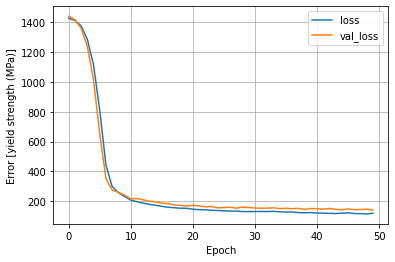

In [ ]:
plot_loss(dnn.fit(x = train_features, y = train_labels, batch_size = 10, validation_split=0.3, verbose = 1, epochs = 50))